Model for Stock Analysis\
Use PANI.JK as an example

In [1]:
import yfinance as yf
import numpy as np
import matplotlib.pyplot as plt 
import pandas as pd
import tensorflow as tf
from sklearn.metrics import mean_absolute_error, mean_squared_error
from prophet import Prophet

Data Extraction

In [ ]:
# Define the stock ticker and the time period
ticker = 'ADRO.JK'
start_date = '2021-01-25'
end_date = '2024-11-25'

# Download the data
stock_data = yf.download(ticker, start=start_date, end=end_date)

# Display the first few rows
print(stock_data.head())


[*********************100%***********************]  1 of 1 completed

Price                       Adj Close   Close    High     Low    Open  \
Ticker                        ADRO.JK ADRO.JK ADRO.JK ADRO.JK ADRO.JK   
Date                                                                    
2021-01-25 00:00:00+00:00  786.802002  1295.0  1350.0  1260.0  1350.0   
2021-01-26 00:00:00+00:00  765.536987  1260.0  1335.0  1230.0  1290.0   
2021-01-27 00:00:00+00:00  756.423584  1245.0  1285.0  1215.0  1260.0   
2021-01-28 00:00:00+00:00  729.082947  1200.0  1275.0  1190.0  1230.0   
2021-01-29 00:00:00+00:00  729.082947  1200.0  1255.0  1160.0  1220.0   

Price                         Volume  
Ticker                       ADRO.JK  
Date                                  
2021-01-25 00:00:00+00:00  142274300  
2021-01-26 00:00:00+00:00  138670800  
2021-01-27 00:00:00+00:00  119157300  
2021-01-28 00:00:00+00:00  201003600  
2021-01-29 00:00:00+00:00  192575300  


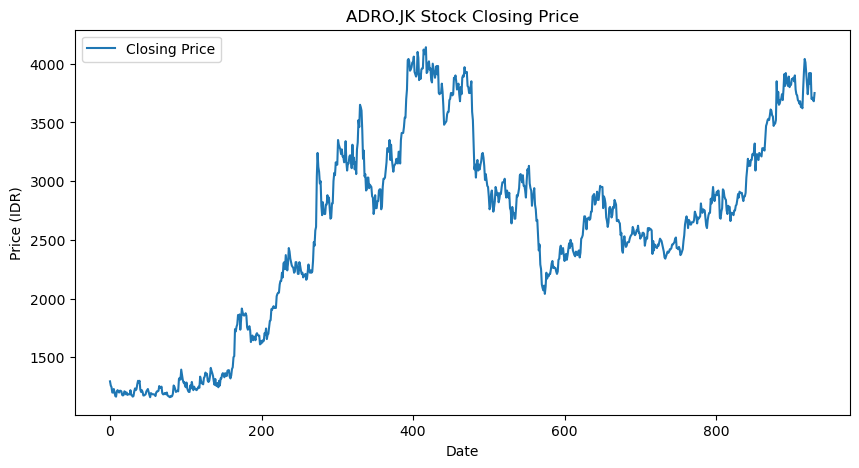

In [20]:
# Plot the closing price
plt.figure(figsize=(10, 5))
plt.plot(stock_data['Close'], label='Closing Price')
plt.title(f'{ticker} Stock Closing Price')
plt.xlabel('Date')
plt.ylabel('Price (IDR)')
plt.legend()
plt.show()


Data Preprocessing

In [ ]:
# Check for missing values
print(stock_data.isnull().sum())

# stock_data.fillna(method='ffill', inplace=True) # If there are any missing values
stock_data.reset_index(inplace=True)
print(stock_data.columns)
print(stock_data.head)


Price      Ticker 
Date                  0
Adj Close  ADRO.JK    0
Close      ADRO.JK    0
High       ADRO.JK    0
Low        ADRO.JK    0
Open       ADRO.JK    0
Volume     ADRO.JK    0
dtype: int64
MultiIndex([(     'Date',        ''),
            ('Adj Close', 'ADRO.JK'),
            (    'Close', 'ADRO.JK'),
            (     'High', 'ADRO.JK'),
            (      'Low', 'ADRO.JK'),
            (     'Open', 'ADRO.JK'),
            (   'Volume', 'ADRO.JK')],
           names=['Price', 'Ticker'])
<bound method NDFrame.head of Price                       Date    Adj Close   Close    High     Low    Open  \
Ticker                                ADRO.JK ADRO.JK ADRO.JK ADRO.JK ADRO.JK   
0      2021-01-25 00:00:00+00:00   786.802002  1295.0  1350.0  1260.0  1350.0   
1      2021-01-26 00:00:00+00:00   765.536987  1260.0  1335.0  1230.0  1290.0   
2      2021-01-27 00:00:00+00:00   756.423584  1245.0  1285.0  1215.0  1260.0   
3      2021-01-28 00:00:00+00:00   729.082947  1200.0  1275.

Feature Selection\
'data' for LSTM\
'prophet_data' for prophet

In [22]:
# 'Close' column to indicate final prices each day
data = stock_data[['Close']]

# Data for prophet
prophet_data = stock_data[['Date','Close']].copy()
prophet_data.rename(columns={'Date': 'ds', 'Close': 'y'}, inplace=True)

# Check the first few rows
print(prophet_data.head())

# Normalization
from sklearn.preprocessing import MinMaxScaler

# Initialize the MinMaxScaler
scaler = MinMaxScaler(feature_range=(0, 1))

# Fit and transform the data
scaled_data = scaler.fit_transform(data)

# Convert back to a DataFrame for easier handling
scaled_data = pd.DataFrame(scaled_data, index=data.index, columns=['Close'])

Price                         ds       y
Ticker                           ADRO.JK
0      2021-01-25 00:00:00+00:00  1295.0
1      2021-01-26 00:00:00+00:00  1260.0
2      2021-01-27 00:00:00+00:00  1245.0
3      2021-01-28 00:00:00+00:00  1200.0
4      2021-01-29 00:00:00+00:00  1200.0


LSTM Model

In [ ]:
# Time-series data sequence and splitting
window_size = 60 # Number of past days used for prediction
X = []
y = []

for i in range(window_size, len(scaled_data)):
    X.append(scaled_data.iloc[i-window_size:i, 0])
    y.append(scaled_data.iloc[i, 0])

# Convert lists to numpy arrays
X, y = np.array(X), np.array(y)

# Reshape X for LSTM (samples, time steps, features)
X = np.reshape(X, (X.shape[0], X.shape[1], 1))

# Define split size
split_ratio = 0.8 # 80% training, 20% testing
split_index = int(len(X) * split_ratio)

# Split the data
X_train, X_test = X[:split_index], X[split_index:]
y_train, y_test = y[:split_index], y[split_index:]

print(f'Training data size: {X_train.shape}, Testing data size: {X_test.shape}')

Training data size: (724, 20, 1), Testing data size: (182, 20, 1)


Model Building and Training

In [ ]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout

# Define the LSTM model
model = Sequential()

# Adding the first LSTM layer with Dropout
model.add(LSTM(units=90, return_sequences=True, input_shape=(X_train.shape[1], 1)))
model.add(Dropout(0.2))

# Adding a second LSTM layer with Dropout
model.add(LSTM(units=90, return_sequences=True))
model.add(Dropout(0.2))

# Adding a third LSTM layer with Dropout
model.add(LSTM(units=90, return_sequences=False))
model.add(Dropout(0.2))

# Adding the output layer
model.add(Dense(units=1))  # Output layer for predicting the next closing price

from tensorflow.keras.optimizers import Adam
# Compile the model
#model.compile(optimizer=Adam(learning_rate=1e-4), loss='mean_absolute_error')
model.compile(optimizer='adam', loss='mean_absolute_error')

# Display the model summary
model.summary()


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 20, 90)            33120     
                                                                 
 dropout (Dropout)           (None, 20, 90)            0         
                                                                 
 lstm_1 (LSTM)               (None, 20, 90)            65160     
                                                                 
 dropout_1 (Dropout)         (None, 20, 90)            0         
                                                                 
 lstm_2 (LSTM)               (None, 90)                65160     
                                                                 
 dropout_2 (Dropout)         (None, 90)                0         
                                                                 
 dense (Dense)               (None, 1)                 9

In [ ]:
# Model Training
# Use callback
from tensorflow.keras.callbacks import EarlyStopping

# Define early stopping callback
callback = EarlyStopping(
    monitor='val_loss',    # Monitor validation loss
    patience=5,            # Number of epochs to wait for improvement
    restore_best_weights=True  # Restore model weights from the epoch with the best value of the monitored quantity
)

# Train the model with early stopping
epochs = 50
batch_size = 64

history = model.fit(
    X_train, y_train, 
    epochs=epochs, 
    batch_size=batch_size, 
    validation_split=0.2, 
    callbacks=[callback]
)

Epoch 1/50
10/10 [==============================] - 9s 244ms/step - loss: 0.0209 - val_loss: 0.0327
Epoch 2/50
10/10 [==============================] - 1s 85ms/step - loss: 0.0087 - val_loss: 0.0474
Epoch 3/50
10/10 [==============================] - 1s 70ms/step - loss: 0.0076 - val_loss: 0.0237
Epoch 4/50
10/10 [==============================] - 1s 70ms/step - loss: 0.0100 - val_loss: 0.0384
Epoch 5/50
10/10 [==============================] - 1s 71ms/step - loss: 0.0072 - val_loss: 0.0287
Epoch 6/50
10/10 [==============================] - 1s 83ms/step - loss: 0.0066 - val_loss: 0.0296
Epoch 7/50
10/10 [==============================] - 1s 85ms/step - loss: 0.0064 - val_loss: 0.0174
Epoch 8/50
10/10 [==============================] - 1s 82ms/step - loss: 0.0067 - val_loss: 0.0482
Epoch 9/50
10/10 [==============================] - 1s 92ms/step - loss: 0.0090 - val_loss: 0.0177
Epoch 10/50
10/10 [==============================] - 1s 84ms/step - loss: 0.0075 - val_loss: 0.0284
Epoch 11

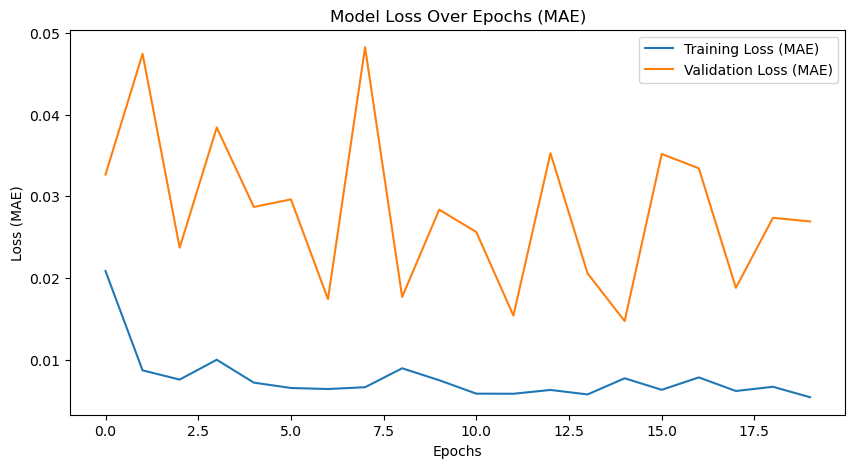

In [ ]:
# Plot Training Result
plt.figure(figsize=(10, 5))
plt.plot(history.history['loss'], label='Training Loss (MAE)')
plt.plot(history.history['val_loss'], label='Validation Loss (MAE)')
plt.title('Model Loss Over Epochs (MAE)')
plt.xlabel('Epochs')
plt.ylabel('Loss (MAE)')
plt.legend()
plt.show()

Model Testing

6/6 [==============================] - 2s 16ms/step


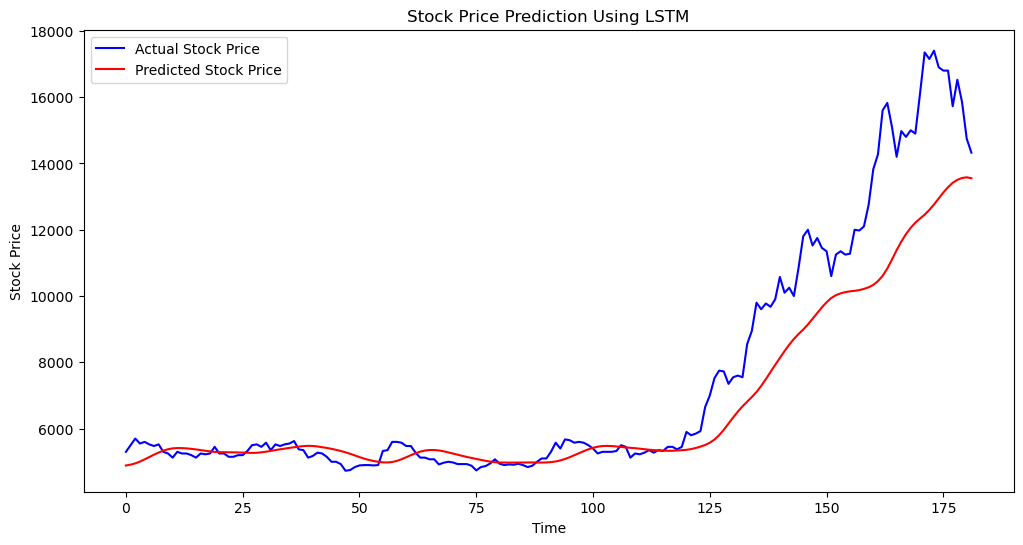

In [ ]:
# Make predictions using the test data
y_pred = model.predict(X_test)

# Inverse transform the predictions and actual values
y_pred = scaler.inverse_transform(y_pred.reshape(-1, 1))
y_test = scaler.inverse_transform(y_test.reshape(-1, 1))

# Plot the actual and predicted price
plt.figure(figsize=(12, 6))
plt.plot(y_test, color='blue', label='Actual Stock Price')
plt.plot(y_pred, color='red', label='Predicted Stock Price')
plt.title('Stock Price Prediction Using LSTM')
plt.xlabel('Time')
plt.ylabel('Stock Price')
plt.legend()
plt.show()


In [ ]:
# Calculate metrics
mae = mean_absolute_error(y_test, y_pred)
mse = mean_squared_error(y_test, y_pred)
rmse = np.sqrt(mse)

print(f"Mean Absolute Error (MAE): {mae:.4f}")
print(f"Mean Squared Error (MSE): {mse:.4f}")
print(f"Root Mean Squared Error (RMSE): {rmse:.4f}")

avg_price = y_test.mean()
mae_percent = (mae / avg_price) * 100
print(f"MAE as a Percentage of Average Price: {mae_percent:.2f}%")

Mean Absolute Error (MAE): 913.1974
Mean Squared Error (MSE): 2265651.5746
Root Mean Squared Error (RMSE): 1505.2081
MAE as a Percentage of Average Price: 12.26%


Prophet Model

In [ ]:
prophet_model = Prophet()
prophet_model.fit(prophet_data)


Save Model

1. LSTM

In [ ]:
from tensorflow.keras.models import save_model

# Save the model to a file
model.save("lstm_ADROJK_model.h5")

2. Prophet

In [ ]:
import pickle

# Save the trained Prophet model
with open('prophet_ADROJK_model.pkl', 'wb') as f:
    pickle.dump(prophet_model, f)